In [1]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import seaborn as sns
sns.set(font_scale=1.2)
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


INITIAL - SALE DATA

In [2]:
sale_df = pd.read_csv('../data/iProperty_sale_to_be_trained.csv')

sale_df.drop(['name','psf','area'], axis=1, inplace=True)

for col in ['price']:
    q_low = sale_df[col].quantile(0.01)
    q_hi  = sale_df[col].quantile(0.99)
    sale_df = sale_df[(sale_df[col] < q_hi) & (sale_df[col] > q_low)]
    
one_hot = pd.get_dummies(sale_df[['district','state','type','details']])
sale_df = sale_df.join(one_hot).drop(['district','state','type','details'], axis=1)

for num in sale_df.drop(['price'], axis=1).dtypes[(sale_df.dtypes == "int64")].index:
    MMS = MinMaxScaler()
    MMS.fit(sale_df[[num]])
    sale_df[num] = MMS.transform(sale_df[[num]])
    
sale_x = sale_df.drop(['price'],axis=1)
sale_y = sale_df['price']

sale_x_train, sale_x_test, sale_y_train, sale_y_test = train_test_split(sale_x,sale_y,test_size=0.2)

MODEL & HYPERPARAMETERS

In [4]:
SEED=42
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=SEED),
    'Random Forest': RandomForestRegressor(random_state=SEED),
    'Support Vector Machine': SVR(),
    'Gradient Boost': GradientBoostingRegressor(random_state=SEED),
    'Neural Network': MLPRegressor(random_state=SEED),
    'XG Boost': XGBRegressor(seed=SEED)
}

In [6]:
dt_hyperparameters = {}

rf_hyperparameters = {
    'n_estimators' : 100
}

sv_hyperparameters = {}

gb_hyperparameters = {
    'n_estimators' : 100,
    'learning_rate' : 0.1,
    'max_depth' : 3,
}

nn_hyperparameters = {'hidden_layer_sizes' : (80,40,20,10)}

xg_hyperparameters = {}

hyperparameters = {
    'Decision Tree'         : dt_hyperparameters,
    'Random Forest'         : rf_hyperparameters,
    'Support Vector Machine': sv_hyperparameters,
    'Gradient Boost'        : gb_hyperparameters,
    'Neural Network'        : nn_hyperparameters,
    'XG Boost'              : xg_hyperparameters
}

In [17]:
score = {
    'score':['R2','RMSE','MAE','MAPE']
}

In [18]:
for key, value in models.items():
    model = value
    model.set_params(**hyperparameters[key])
    model.fit(sale_x_train,sale_y_train)
    sale_y_pred = model.predict(sale_x_test)
    
    score[key] = []
    score[key].append(r2_score(sale_y_test,sale_y_pred))
    score[key].append(mean_squared_error(sale_y_test,sale_y_pred, squared=False))
    score[key].append(mean_absolute_error(sale_y_test,sale_y_pred))
    score[key].append(mean_absolute_percentage_error(sale_y_test,sale_y_pred))
    print(key + ': Score is ready')

Decision Tree: Score is ready
Random Forest: Score is ready
Support Vector Machine: Score is ready
Gradient Boost: Score is ready


C:\Users\DS\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network: Score is ready
XG Boost: Score is ready


In [19]:
score

{'score': ['R2', 'RMSE', 'MAE', 'MAPE'],
 'Decision Tree': [0.6556461593261058,
  610387.7306842763,
  296617.60233903007,
  0.28046528651613695],
 'Random Forest': [0.7554229506082955,
  514412.10581706243,
  258585.9042484704,
  0.25193793604736053],
 'Support Vector Machine': [-0.11297308377180237,
  1097351.244447578,
  596474.5135846013,
  0.6080692575189498],
 'Gradient Boost': [0.7383778379853572,
  532035.4796766646,
  308458.11697428237,
  0.3479151231289075],
 'Neural Network': [0.7790160678471107,
  488971.6481220113,
  265393.6248322357,
  0.2627607046300696],
 'XG Boost': [0.7887202823331128,
  478114.85090789956,
  262251.32305938826,
  0.2756039671322596]}

In [20]:
score_df = pd.DataFrame(score).T
score_df.columns = score_df.iloc[0]
score_df = score_df[1:]
score_df = score_df.reset_index()
score_df.rename(columns={'index':'model'}, inplace=True)
score_df

score,model,R2,RMSE,MAE,MAPE
0,Decision Tree,0.655646,610387.730684,296617.602339,0.280465
1,Random Forest,0.755423,514412.105817,258585.904248,0.251938
2,Support Vector Machine,-0.112973,1097351.244448,596474.513585,0.608069
3,Gradient Boost,0.738378,532035.479677,308458.116974,0.347915
4,Neural Network,0.779016,488971.648122,265393.624832,0.262761
5,XG Boost,0.78872,478114.850908,262251.323059,0.275604


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network'),
  Text(5, 0, 'XG Boost')])

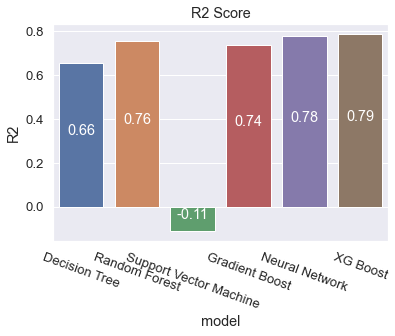

In [21]:
p = sns.barplot(data=score_df, x='model', y='R2')
p.set_title('R2 Score')
for i in range(len(score_df)):
    p.text(i,score_df.R2[i]/2,str(round(score_df.R2[i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network'),
  Text(5, 0, 'XG Boost')])

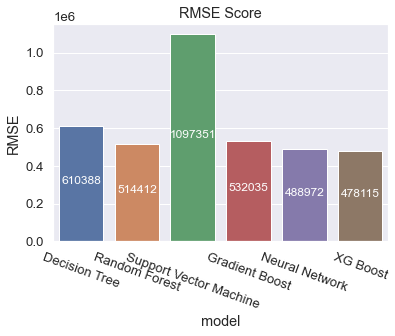

In [22]:
p = sns.barplot(data=score_df, x='model', y='RMSE')
p.set_title('RMSE Score')
for i in range(len(score_df)):
    p.text(i,score_df.RMSE[i]/2,str(round(score_df.RMSE[i])),
           fontdict=dict(color='white', fontsize=12),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network'),
  Text(5, 0, 'XG Boost')])

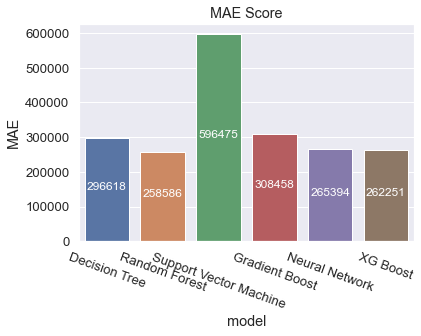

In [23]:
p = sns.barplot(data=score_df, x='model', y='MAE')
p.set_title('MAE Score')
for i in range(len(score_df)):
    p.text(i,score_df.MAE[i]/2,str(round(score_df.MAE[i])),
           fontdict=dict(color='white', fontsize=12),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Decision Tree'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'Support Vector Machine'),
  Text(3, 0, 'Gradient Boost'),
  Text(4, 0, 'Neural Network'),
  Text(5, 0, 'XG Boost')])

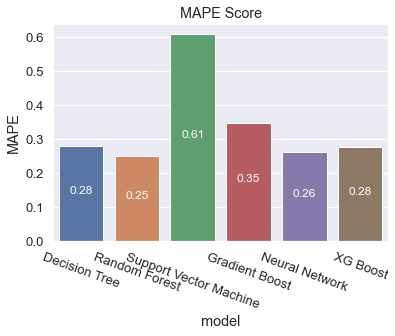

In [24]:
p = sns.barplot(data=score_df, x='model', y='MAPE')
p.set_title('MAPE Score')
for i in range(len(score_df)):
    p.text(i,score_df.MAPE[i]/2,str(round(score_df.MAPE[i],2)),
           fontdict=dict(color='white', fontsize=12),
          horizontalalignment='center')
plt.xticks(rotation=-20)